In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/
!pip install skrebate

Mounted at /content/gdrive
/content/gdrive/MyDrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29269 sha256=3ceeb5f2a84d80ae91624e15c0a4529d4a9f61354a02f4eb5c2de7d56dbf22a8
  Stored in directory: /root/.cache/pip/wheels/1e/93/22/f83048fc1dafedcec44bb4ccf8d08225da96d20115d97a7a77
Successfully built skrebate


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from itertools import product
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, f_classif
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from model import *

# 数据读取以及预处理

首先将所有的数据读取导入：

In [3]:
df_train_dataset = pd.read_csv("train_feature.csv")
df_train_label = pd.read_csv("train_label.csv")
df_test_dataset = pd.read_csv("test_feature.csv")

我们首先查看训练集的信息：

In [4]:
df_train_dataset

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119
0,48.0,9.804220,0.064283,6.0,5.0,211.0,45.0,8.0,3.0,2.711200,...,4.0,1.157242,44.0,0.027881,1.122944,0.0,47.0,1.732584,2.0,52.0
1,45.0,-15.118262,0.590192,10.0,2.0,141.0,48.0,7.0,1.0,3.276093,...,4.0,0.583108,62.0,0.852767,4.685032,1.0,38.0,0.601408,2.0,44.0
2,56.0,1.691250,0.173249,8.0,1.0,251.0,47.0,6.0,1.0,1.082628,...,6.0,0.741096,62.0,0.907026,0.927391,2.0,53.0,2.129846,1.0,46.0
3,50.0,5.867626,0.004743,8.0,3.0,186.0,39.0,8.0,1.0,2.992557,...,5.0,1.173169,60.0,0.165119,7.096296,1.0,56.0,0.474665,2.0,38.0
4,49.0,-6.160454,0.709718,9.0,3.0,240.0,57.0,6.0,1.0,3.189316,...,5.0,1.068687,54.0,0.600518,4.988225,7.0,52.0,1.187483,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,67.0,1.279090,0.143929,10.0,3.0,210.0,51.0,8.0,1.0,0.670449,...,10.0,1.435415,50.0,0.607483,1.328274,4.0,49.0,0.707751,1.0,52.0
9996,56.0,4.814346,0.697155,6.0,6.0,267.0,44.0,9.0,2.0,0.580825,...,2.0,0.334893,63.0,0.237845,1.219853,1.0,55.0,0.555282,4.0,52.0
9997,57.0,-0.271178,0.579603,8.0,5.0,168.0,57.0,8.0,5.0,14.266668,...,6.0,1.366215,45.0,0.491556,1.428329,2.0,59.0,1.565160,2.0,41.0
9998,52.0,-1.022212,0.839743,8.0,1.0,242.0,37.0,10.0,3.0,0.695831,...,5.0,0.561938,55.0,0.508272,3.113039,1.0,60192.0,0.727227,3.0,65.0


可以发现，存在空缺值和离群数据，因此我们需要对这两个问题进行处理：

空缺值的处理方式：

- 直接将含有空缺值的数据去除（这样做会使得数据集规模变小）
- 用平均值替换空缺值（这样可以保留原有的数据集规模）

离群数据的处理方式：

- 采用箱型图来确认离群数据，并且再确认之后用缺失值替换离群数据（目的也是为了保留原有的数据集规模）

并且从文档中知，数据集中可能存在大量冗余随机特征，因此我们需要去除冗余的特征数据：
- 将冗余的特征数据删除

因为数据集的维数过大，我们也可以做一定的特征提取工作.

对数据集进行去除离群点，填补空值，标准化，以及特征筛选：

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


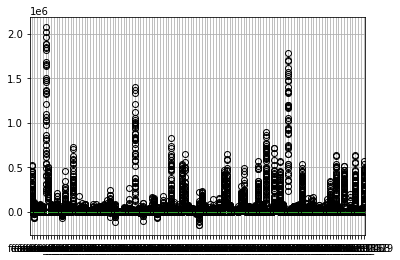

In [5]:
ds = dataset_drop_outlier(df_train_dataset)
ds = dataset_drop_duplicate(ds)
ds = dataset_replace_null(ds)
ds = dataset_norm(ds, method='z-score')

In [6]:
ds_lda = dataset_select_features(ds, df_train_label, method='lda')

# 数据划分以及模型训练

## 逻辑斯蒂回归模型



当采用默认的参数进行训练时：

holdout-model's average accuracy score is 0.3056.


[0.304, 0.3135, 0.3015, 0.302, 0.307]

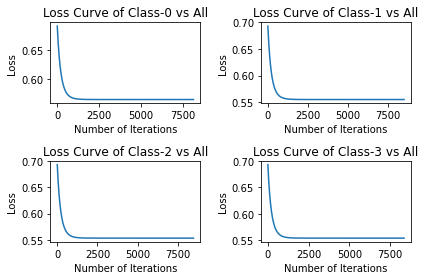

In [ ]:
lr_model_default = LogisticRegression()
holdout5_eval(lr_model_default, ds_lda, df_train_label, "LogisticRegression")

cross validation-model's average accuracy score is 0.3069.


[0.3035, 0.3095, 0.3045, 0.3095, 0.3075]

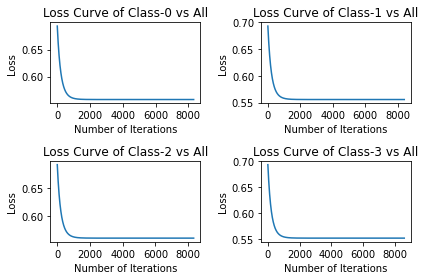

In [ ]:
crossvalid5_eval(lr_model_default, ds_lda, df_train_label, "LogisticRegression")

对模型进行自动调参，这里采用类似 `GridSearchCV` 的方法，将所有待选参数用列表存储，然后进行穷搜的方式，尝试得到最好的参数：

In [ ]:
from itertools import product
penaltys = ["l1", "l2"]
lrs = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
tols = [1e-5, 5e-5, 1e-4, 5e-4]
best_accuracy = 0
best_param = None
X_train, Y_train, X_test, Y_test = dataset_split(ds_lda, df_train_label, 0.8, 3333)
for param in product(penaltys, lrs, tols):
    model = LogisticRegression(penalty=param[0], lr=param[1], tol=param[2], max_iter=5e3)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_param = param
print(best_param)

('l1', 0.001, 1e-05)


使用留出法进行划分数据集训练并评估模型：

holdout-model's average accuracy score is 0.3056.


[0.304, 0.3145, 0.3015, 0.302, 0.306]

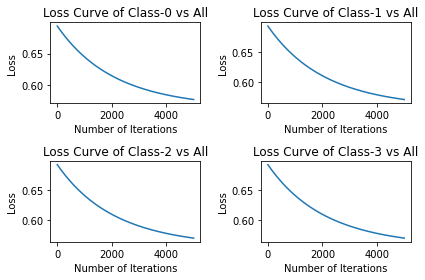

In [ ]:
lr_model = LogisticRegression(penalty="l1", lr=0.001, tol=1e-5, max_iter=5e3)
holdout5_eval(lr_model, ds_lda, df_train_label, "LogisticRegression")

使用交叉验证法进行划分数据集训练并评估模型：

cross validation-model's average accuracy score is 0.30789999999999995.


[0.3055, 0.31, 0.3045, 0.31, 0.3095]

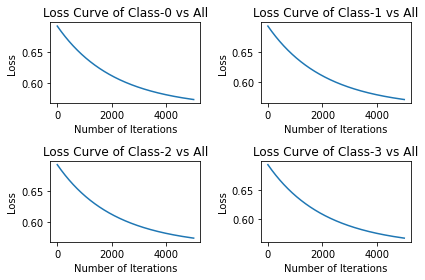

In [ ]:
crossvalid5_eval(lr_model, ds_lda, df_train_label, "LogisticRegression")

## XGBoost模型



当采用默认的参数进行训练时：

holdout-model's average accuracy score is 0.2952.


[0.2905, 0.2965, 0.296, 0.299, 0.294]

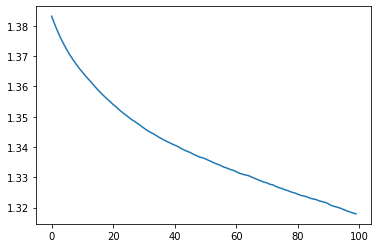

In [ ]:
xgb_model_default = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    booster='gbtree',
)
holdout5_eval(xgb_model_default, ds_lda, df_train_label, "XGBoost")

cross validation-model's average accuracy score is 0.2981.


[0.298, 0.3005, 0.311, 0.2975, 0.2835]

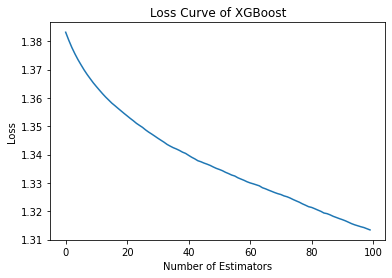

In [ ]:
crossvalid5_eval(xgb_model_default, ds_lda, df_train_label, "XGBoost")

对模型进行自动调参:

{'gamma': 1e-05, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3}


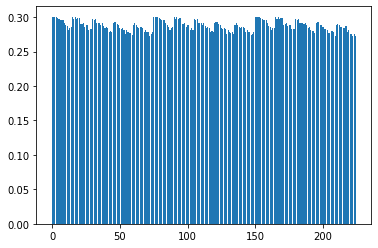

In [ ]:
xgb_param = XGBClassifier(
    nthread=-1,
    n_estimators=100,
    objective='multi:softmax',
    num_class=4,
    booster='gbtree',
    early_stopping_rounds=5,
    #tree_method='gpu_hist',
)
params = [{'min_child_weight': [1, 2, 3], 'max_depth': [3, 4, 5, 6, 7], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'gamma': [1e-5, 1e-4, 1e-3]}]
best_params = get_best_param(xgb_param, ds_lda, df_train_label, params, False)
print(best_params)

使用留出法进行划分数据集训练并评估模型：

holdout-model's average accuracy score is 0.2989.


[0.29, 0.297, 0.305, 0.298, 0.3045]

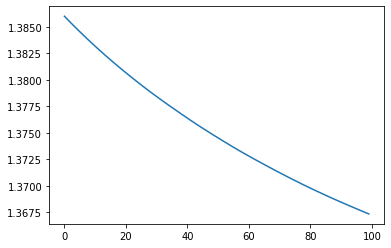

In [ ]:
from xgboost.sklearn import XGBClassifier
xgb_model = XGBClassifier(
    nthread=-1,
    n_estimators=100,
    objective='multi:softmax',
    num_class=4,
    booster='gbtree',
    early_stopping_rounds=5,
    tree_method='gpu_hist',
    min_child_weight=3,
    max_depth=3,
    learning_rate=0.01,
    gamma=1e-5,
)

holdout5_eval(xgb_model, ds_lda, df_train_label, "XGBoost")

使用交叉验证法进行划分数据集训练并评估模型：

cross validation-model's average accuracy score is 0.3016.


[0.2995, 0.3045, 0.305, 0.3055, 0.2935]

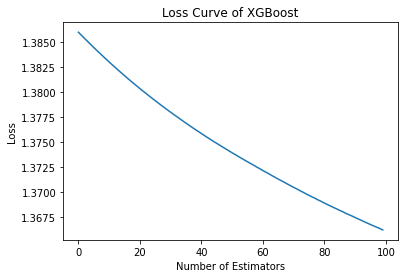

In [ ]:
crossvalid5_eval(xgb_model, ds_lda, df_train_label, "XGBoost")

## 神经网络模型


当采用默认的参数进行训练时：

In [ ]:
nn_model_default = MLPClassifier()
holdout5_eval(nn_model_default, ds_lda, df_train_label, "NeuralNetwork")
crossvalid5_eval(nn_model_default, ds_lda, df_train_label, "NeuralNetwork")

holdout-model's average accuracy score is 0.306.
cross validation-model's average accuracy score is 0.3001.


[0.2885, 0.298, 0.305, 0.302, 0.307]

对模型进行自动调参:

{'alpha': 0.05, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}


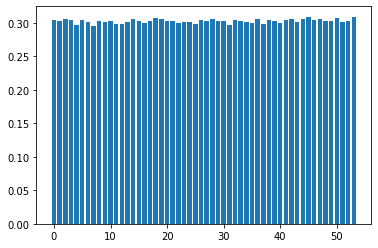

In [ ]:
from sklearn.neural_network import MLPClassifier

nn_param = MLPClassifier(
    max_iter=2000,
    activation='relu',
    solver='adam',
    learning_rate='constant',
    batch_size='auto',
)

params = [{'hidden_layer_sizes': [(64, ), (100, ), (128, )], 'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], 'learning_rate_init': [0.001, 0.005, 0.01]}]
best_params = get_best_param(nn_param, ds_lda, df_train_label, params, False)
print(best_params)

使用留出法进行划分数据集训练并评估模型：

In [ ]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(
    max_iter=2000,
    activation='relu',
    solver='adam',
    learning_rate='constant',
    batch_size='auto',
    alpha=0.05,
    hidden_layer_sizes=(64, ),
    learning_rate_init=0.001
)
holdout5_eval(nn_model, ds_lda, df_train_label, "NeuralNetwork")

holdout-model's average accuracy score is 0.3055.


[0.299, 0.309, 0.3005, 0.3085, 0.3105]

使用交叉验证法进行划分数据集训练并评估模型：

In [ ]:
crossvalid5_eval(nn_model, ds_lda, df_train_label, "NeuralNetwork")

cross validation-model's average accuracy score is 0.30569999999999997.


[0.294, 0.3075, 0.314, 0.305, 0.308]

## 决策树模型



当采用默认的参数进行训练时：

In [ ]:
dt_model_default = DecisionTreeClassifier()
holdout5_eval(dt_model_default, ds_lda, df_train_label, "DecisionTree")
crossvalid5_eval(dt_model_default, ds_lda, df_train_label, "DecisionTree")

holdout-model's average accuracy score is 0.2568.
cross validation-model's average accuracy score is 0.2644.


[0.2515, 0.2645, 0.271, 0.268, 0.267]

对模型进行自动调参:

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


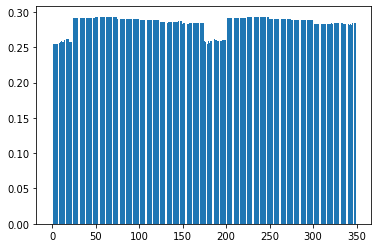

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_param = DecisionTreeClassifier(

)

params = [{'criterion': ['entropy', 'gini'], 'max_depth': [None, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4, 5]}]
best_params = get_best_param(dt_param, ds_lda, df_train_label, params, False)
print(best_params)

使用留出法进行划分数据集训练并评估模型：

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
)
holdout5_eval(dt_model, ds_lda, df_train_label, "DecisionTree")

holdout-model's average accuracy score is 0.2959.


[0.279, 0.3015, 0.301, 0.296, 0.302]

使用交叉验证法进行划分数据集训练并评估模型：

In [ ]:
crossvalid5_eval(dt_model, ds_lda, df_train_label, "DecisionTree")

cross validation-model's average accuracy score is 0.29429999999999995.


[0.284, 0.2935, 0.2915, 0.3115, 0.291]

## 支持向量机模型

当采用默认的参数进行训练时：

holdout-model's average accuracy score is 0.30569999999999997.


[0.3035, 0.314, 0.3025, 0.3005, 0.308]

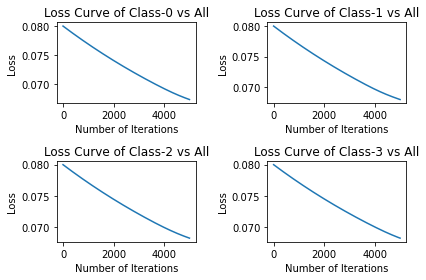

In [ ]:
svm_model_default = SVM()
holdout5_eval(svm_model_default, ds_lda, df_train_label, "SVM")

cross validation-model's average accuracy score is 0.306.


[0.2995, 0.307, 0.3045, 0.31, 0.309]

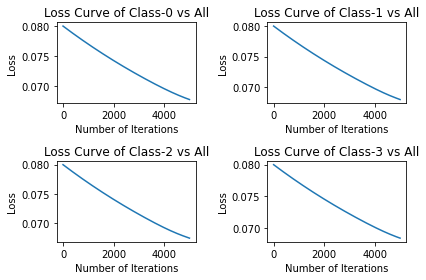

In [ ]:
crossvalid5_eval(svm_model_default, ds_lda, df_train_label, "SVM")

对模型进行自动调参，这里采用类似 GridSearchCV 的方法，将所有待选参数用列表存储，然后进行穷搜的方式，尝试得到最好的参数：

In [ ]:
from itertools import product
C1s = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
C2s = [1e-5, 5e-5, 1e-4, 5e-4]
lrs = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
best_accuracy = 0
best_param = None
X_train, Y_train, X_test, Y_test = dataset_split(ds_lda, df_train_label, 0.8, 3333)
for param in product(C1s, C2s, lrs):
    model = SVM(C1=param[0], C2=param[1], lr=param[2], tol=1e-3, max_iter=5e3)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_param = param
print(best_param)

(0.025, 1e-05, 0.01)


使用留出法进行划分数据集训练并评估模型：

holdout-model's average accuracy score is 0.3058.


[0.3045, 0.3145, 0.302, 0.302, 0.306]

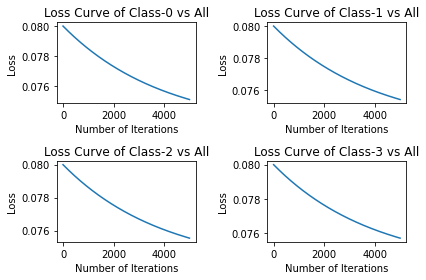

In [ ]:
svm_model = SVM(C1=0.025, C2=1e-5, lr=0.01, max_iter=5e3)
holdout5_eval(svm_model, ds_lda, df_train_label, "SVM")

使用交叉验证法进行划分数据集训练并评估模型：

cross validation-model's average accuracy score is 0.3077.


[0.3055, 0.3095, 0.3045, 0.309, 0.31]

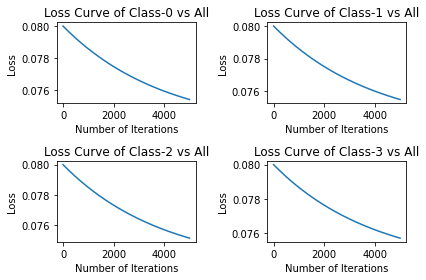

In [ ]:
crossvalid5_eval(svm_model, ds_lda, df_train_label, "SVM")

# 其余数据处理以及模型训练

首先得到其它特征选取方式处理后的数据集

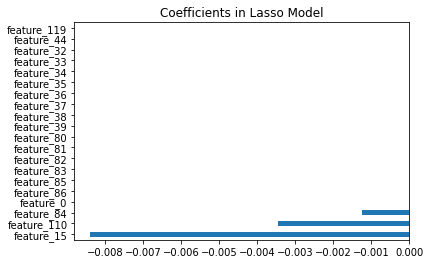

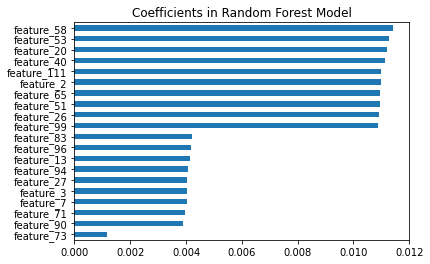

In [ ]:
ds_lasso = dataset_select_features(ds, df_train_label, method='lasso')
ds_f_classif = dataset_select_features(ds, df_train_label, method='f_classif')
ds_mutual_info = dataset_select_features(ds, df_train_label, method='mutual_info')
ds_random_forest = dataset_select_features(ds, df_train_label, method='random_forest')
ds_relief_f = dataset_select_features(ds, df_train_label, method='relief-f')

将这些数据集在决策树模型上进行训练

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
)

holdout5_eval(dt_model, ds_lasso, df_train_label, "DecisionTree")
holdout5_eval(dt_model, ds_f_classif, df_train_label, "DecisionTree")
holdout5_eval(dt_model, ds_mutual_info, df_train_label, "DecisionTree")
holdout5_eval(dt_model, ds_random_forest, df_train_label, "DecisionTree")
holdout5_eval(dt_model, ds_relief_f, df_train_label, "DecisionTree")

holdout-model's average accuracy score is 0.25.
holdout-model's average accuracy score is 0.2503.
holdout-model's average accuracy score is 0.25570000000000004.
holdout-model's average accuracy score is 0.2428.
holdout-model's average accuracy score is 0.25040000000000007.


[0.257, 0.2605, 0.2435, 0.2555, 0.2355]

In [ ]:
crossvalid5_eval(dt_model, ds_lasso, df_train_label, "DecisionTree")
crossvalid5_eval(dt_model, ds_f_classif, df_train_label, "DecisionTree")
crossvalid5_eval(dt_model, ds_mutual_info, df_train_label, "DecisionTree")
crossvalid5_eval(dt_model, ds_random_forest, df_train_label, "DecisionTree")
crossvalid5_eval(dt_model, ds_relief_f, df_train_label, "DecisionTree")

cross validation-model's average accuracy score is 0.25389999999999996.
cross validation-model's average accuracy score is 0.24359999999999998.
cross validation-model's average accuracy score is 0.24620000000000003.
cross validation-model's average accuracy score is 0.2291.
cross validation-model's average accuracy score is 0.24220000000000003.


[0.248, 0.2335, 0.246, 0.2495, 0.234]

若先利用上述方法进行特征选取，选出一些重要的特征之后，再进行 LDA 特征提取：

In [7]:
ds_mutual_info_1 = dataset_select_features(ds, df_train_label, method='mutual_info')
ds_lda_1 = dataset_select_features(ds_mutual_info_1, df_train_label, method='lda')
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
)
holdout5_eval(dt_model, ds_lda_1, df_train_label, "DecisionTree")
crossvalid5_eval(dt_model, ds_lda_1, df_train_label, "DecisionTree")

holdout-model's average accuracy score is 0.26080000000000003.
cross validation-model's average accuracy score is 0.26030000000000003.


[0.2695, 0.2585, 0.254, 0.257, 0.2625]

# 假设检验操作

为了对这些模型进行检验，继续在几个数据集上进行留出法预测：

holdout-model's average accuracy score is 0.27480000000000004.


[0.28, 0.2805, 0.268, 0.262, 0.2835]

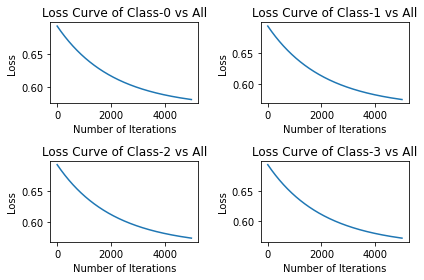

In [8]:
lr_model = LogisticRegression(penalty="l1", lr=0.001, tol=1e-5, max_iter=5e3)
holdout5_eval(lr_model, ds_lda_1, df_train_label, "LogisticRegression")

holdout-model's average accuracy score is 0.2643000000000001.


[0.257, 0.2765, 0.2675, 0.257, 0.2635]

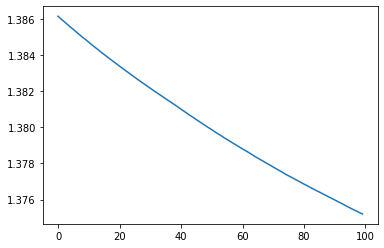

In [10]:
xgb_model = XGBClassifier(
    nthread=-1,
    n_estimators=100,
    objective='multi:softmax',
    num_class=4,
    booster='gbtree',
    early_stopping_rounds=5,
    #tree_method='gpu_hist',
    min_child_weight=3,
    max_depth=3,
    learning_rate=0.01,
    gamma=1e-5,
)
holdout5_eval(xgb_model, ds_lda_1, df_train_label, "XGBoost")

In [11]:
nn_model = MLPClassifier(
    max_iter=2000,
    activation='relu',
    solver='adam',
    learning_rate='constant',
    batch_size='auto',
    alpha=0.05,
    hidden_layer_sizes=(64, ),
    learning_rate_init=0.001
)
holdout5_eval(nn_model, ds_lda_1, df_train_label, "NeuralNetwork")

holdout-model's average accuracy score is 0.26239999999999997.


[0.2595, 0.2675, 0.257, 0.257, 0.271]

holdout-model's average accuracy score is 0.2751.


[0.281, 0.281, 0.269, 0.261, 0.2835]

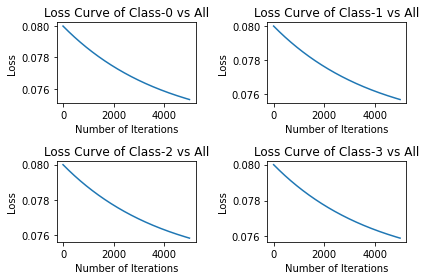

In [12]:
svm_model = SVM(C1=0.025, C2=1e-5, lr=0.01, max_iter=5e3)
holdout5_eval(svm_model, ds_lda_1, df_train_label, "SVM")

同样地，在选取一个数据集，进行相同操作：

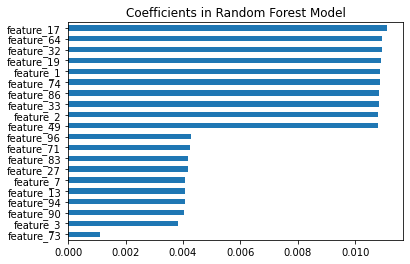

In [13]:
ds_random_forest_1 = dataset_select_features(ds, df_train_label, method='random_forest')
ds_lda_2 = dataset_select_features(ds_random_forest_1, df_train_label, method='lda')

holdout-model's average accuracy score is 0.27480000000000004.


[0.289, 0.274, 0.2755, 0.2685, 0.267]

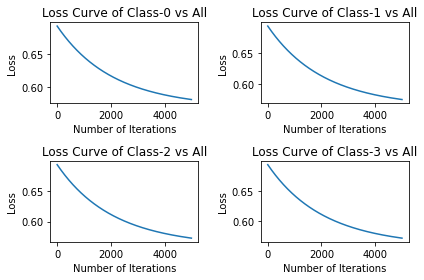

In [14]:
holdout5_eval(lr_model, ds_lda_2, df_train_label, "LogisticRegression")

holdout-model's average accuracy score is 0.2651.


[0.2715, 0.264, 0.2645, 0.266, 0.2595]

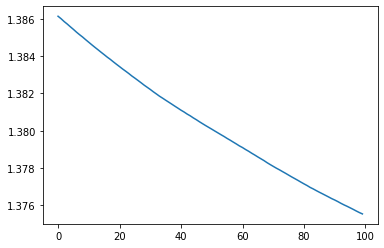

In [15]:
holdout5_eval(xgb_model, ds_lda_2, df_train_label, "XGBoost")

In [16]:
holdout5_eval(nn_model, ds_lda_2, df_train_label, "NeuralNetwork")

holdout-model's average accuracy score is 0.26830000000000004.


[0.2795, 0.26, 0.272, 0.2735, 0.2565]

In [17]:
holdout5_eval(dt_model, ds_lda_2, df_train_label, "DecisionTree")

holdout-model's average accuracy score is 0.26370000000000005.


[0.2815, 0.258, 0.254, 0.26, 0.265]

holdout-model's average accuracy score is 0.2744.


[0.2885, 0.2745, 0.275, 0.2675, 0.2665]

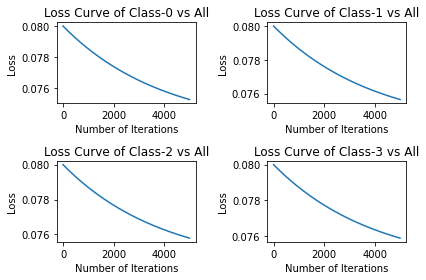

In [18]:
holdout5_eval(svm_model, ds_lda_2, df_train_label, "SVM")

# 最终的模型选择

从上述的性能看来，最终选择 SVM 来预测测试集。对测试集进行同样的数据预处理操作：

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


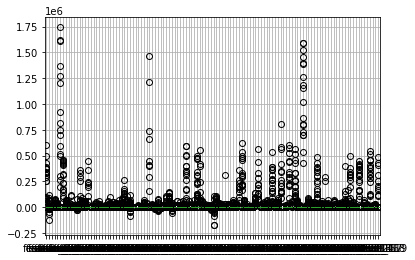

In [ ]:
ds_test = dataset_drop_outlier(df_test_dataset)
ds_test = dataset_drop_duplicate(ds_test)
ds_test = dataset_replace_null(ds_test)
ds_test = dataset_norm(ds_test, method='z-score')

为了对预测测试集进行降维，利用训练集的信息，对其进行特征提取操作：

In [ ]:
lda_model = LDA(n_components=3)
lda_model.fit(ds, np.array(df_train_label).flatten())
ds_test_lda = lda_model.transform(np.array(ds_test))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


从上述的总体性能看来，最后的模型选择 SVM 来预测测试集:

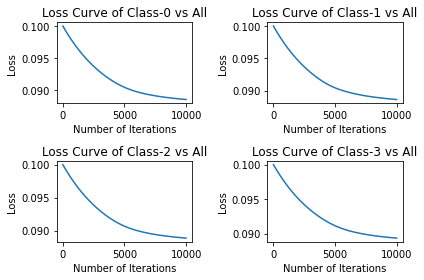

In [ ]:
svm_model_test = SVM(C1=0.025, C2=1e-5, lr=0.01, max_iter=1e4)
svm_model_test.fit(np.array(ds_lda), np.array(df_train_label).flatten())
y_pred = svm_model_test.predict(ds_test_lda)
svm_model_test.draw_loss_curve()

保存预测结果到 `train_label.csv` 文件当中。

In [ ]:
output = pd.DataFrame({'label': y_pred})
output.to_csv('test_label.csv', index=False)